In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder


# Incident Prediction

In [6]:
df = pd.read_csv("../data/processed/energy_data.csv", sep=';', decimal=',')
print(df.head())

               date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0  01/01/2018 00:15       3.17                                  2.95   
1  01/01/2018 00:30       4.00                                  4.46   
2  01/01/2018 00:45       3.24                                  3.28   
3  01/01/2018 01:00       3.31                                  3.56   
4  01/01/2018 01:15       3.82                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                         100.0   900   
1                         66.77                         100.0  1800   
2                         70.

In [7]:
print(df.info())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
 11  country        

In [8]:
df["failure_reason"].fillna("None", inplace = True)

C:\Users\phili\AppData\Local\Temp\ipykernel_13808\429581854.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["failure_reason"].fillna("None", inplace = True)


In [9]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

In [10]:
print(df['Usage_kWh'].describe())

count    35040.000000
mean        27.386892
std         33.444380
min          0.000000
25%          3.200000
50%          4.570000
75%         51.237500
max        157.180000
Name: Usage_kWh, dtype: float64


C:\Users\phili\AppData\Local\Temp\ipykernel_13808\1903783084.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Usage_kWh', palette='viridis')


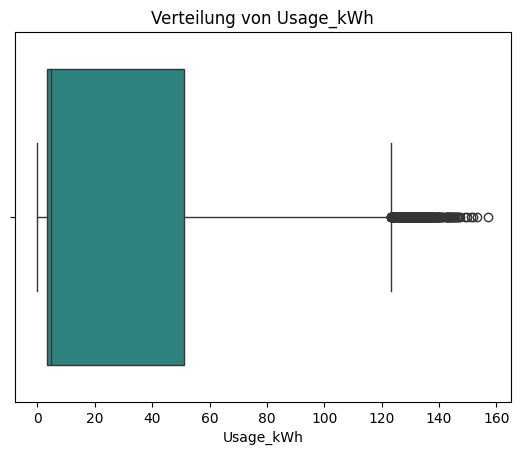

In [11]:

sns.boxplot(data=df, x='Usage_kWh', palette='viridis')
plt.title(f'Verteilung von Usage_kWh')
plt.show()


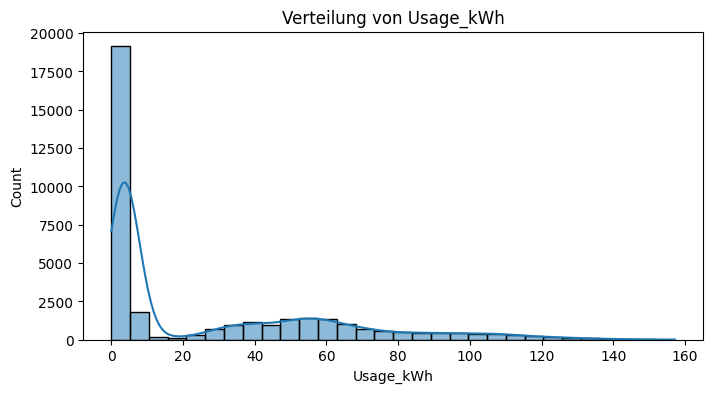

In [12]:
plt.figure(figsize=(8, 4))
sns.histplot(df["Usage_kWh"], kde=True, bins=30)
plt.title(f'Verteilung von Usage_kWh')
plt.show()


In [13]:
df['Usage_kWh'] = np.clip(df['Usage_kWh'], 0, df['Usage_kWh'].quantile(0.95))


In [14]:
cost_per_kwh = 0.30
df['Energy_Cost'] = df['Usage_kWh'] * cost_per_kwh

# Gesamtkosten pro Kategorie
category_costs = df.groupby('product_category')['Energy_Cost'].sum().reset_index()
print(category_costs)

    product_category  Energy_Cost
0               50'S      618.924
1              ALARM     1530.855
2           ALPHABET     1565.607
3                AND     9755.562
4            ANTIQUE       71.970
..               ...          ...
153             WOOD     1114.914
154             WRAP      206.793
155           YELLOW      130.080
156             ZINC      609.492
157            other     7307.247

[158 rows x 2 columns]


In [15]:
# Häufigkeit der Fehlergründe
failure_counts = df['failure_reason'].value_counts()
print(failure_counts)


failure_reason
None                       29315
incorrect data              1769
network failure             1181
human error                 1153
incorrect configuration      544
machine failure              541
insufficient capacity        283
insufficient resources       254
Name: count, dtype: int64


In [16]:
# Durchschnittlicher Energieverbrauch bei Störungen
failure_analysis = df.groupby('failure_reason')['Usage_kWh'].mean().reset_index()
print(failure_analysis)


            failure_reason  Usage_kWh
0                     None  31.322329
1              human error   2.809705
2  incorrect configuration   2.812169
3           incorrect data   2.808084
4    insufficient capacity   2.803604
5   insufficient resources   2.808504
6          machine failure   2.811275
7          network failure   2.805868


In [17]:
# One-Hot-Encoding für kategorische Spalten
df_encoded = pd.get_dummies(df, columns=['Load_Type', 'country', 'product_category', 'WeekStatus', 'Day_of_week'])


In [18]:
df_encoded = df_encoded.drop(columns=['date', 'Energy_Cost'])

In [19]:

# Zielvariable und Features
X = df_encoded.drop(columns=['failure_reason'])
y = df_encoded['failure_reason']

# Training- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Modell erstellen
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Vorhersagen
y_pred = model.predict(X_test)

# Genauigkeit prüfen
accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit des Modells: {accuracy:.2f}")


Genauigkeit des Modells: 0.87


In [21]:
# Wahrscheinlichkeiten vorhersagen
probs = model.predict_proba(X_test)

# Zuordnung der Wahrscheinlichkeiten zu den Klassen
failure_probs = pd.DataFrame(probs, columns=model.classes_)
print(failure_probs.head())


   None  human error  incorrect configuration  incorrect data  \
0   0.0          0.0                      1.0             0.0   
1   1.0          0.0                      0.0             0.0   
2   1.0          0.0                      0.0             0.0   
3   1.0          0.0                      0.0             0.0   
4   1.0          0.0                      0.0             0.0   

   insufficient capacity  insufficient resources  machine failure  \
0                    0.0                     0.0              0.0   
1                    0.0                     0.0              0.0   
2                    0.0                     0.0              0.0   
3                    0.0                     0.0              0.0   
4                    0.0                     0.0              0.0   

   network failure  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  


In [23]:
# Zielvariable kodieren
label_encoder = LabelEncoder()
df['failure_reason_encoded'] = label_encoder.fit_transform(df['failure_reason'])

# One-Hot-Encoding der Zielvariable
y = to_categorical(df['failure_reason_encoded'])

# One-Hot-Encoding für kategorische Features und Skalierung
X = pd.get_dummies(df.drop(columns=['failure_reason', 'failure_reason_encoded', 'date']), drop_first=True)

# Numerische Werte skalieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Training- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [24]:
# Modell erstellen
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),  # Eingabeschicht
    Dense(64, activation='relu'),                               # Versteckte Schicht
    Dense(y_train.shape[1], activation='softmax')               # Ausgabeschicht
])

# Modell kompilieren
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\phili\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Modell trainieren
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

# Ergebnisse auswerten
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Genauigkeit des Modells: {accuracy:.2f}")


In [ ]:
from sklearn.metrics import classification_report

# Modell evaluieren
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Genauigkeit des Modells: {accuracy:.2f}")

# Vorhersagen
y_pred_probs = model.predict(X_test)  # Wahrscheinlichkeiten
y_pred_classes = y_pred_probs.argmax(axis=1)  # Vorhergesagte Klassen
y_test_classes = y_test.argmax(axis=1)  # Wahre Klassen

# Klassifikationsbericht
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))


In [ ]:
failure_probs = pd.DataFrame(y_pred_probs, columns=label_encoder.classes_)
print(failure_probs.head())

In [ ]:
import matplotlib.pyplot as plt

# Genauigkeit
plt.plot(history.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.legend()
plt.title('Trainings- und Validierungsgenauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.show()

# Verlust
plt.plot(history.history['loss'], label='Trainingsverlust')
plt.plot(history.history['val_loss'], label='Validierungsverlust')
plt.legend()
plt.title('Trainings- und Validierungsverlust')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Ergebnisse sortieren und plotten
model_results = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy']).sort_values(by='Accuracy', ascending=False)
model_results.plot(kind='bar', legend=False, color='skyblue')
plt.title('Genauigkeitsvergleich der Modelle')
plt.ylabel('Genauigkeit')
plt.show()


In [112]:
# Zielvariable und Features
X = df_encoded.drop(columns=['failure_reason'])
y = df_encoded['failure_reason']

# Training- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [144]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Zielvariable kodieren
label_encoder = LabelEncoder()
df['failure_reason_encoded'] = label_encoder.fit_transform(df['failure_reason'])

# One-Hot-Encoding für kategorische Merkmale
X = pd.get_dummies(df.drop(columns=['failure_reason', 'failure_reason_encoded', 'date']), drop_first=True)

# Skalierung der numerischen Merkmale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Zielvariable und Features definieren
y = df['failure_reason_encoded']

# Training- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [145]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# XGBoost-Modell definieren
model = XGBClassifier(
    use_label_encoder=False,  # Verhindert Warnungen bei neueren Versionen
    eval_metric='logloss',   # Bewertungsmetrik
    random_state=42
)

# Modell trainieren
model.fit(X_train, y_train)

# Vorhersagen
y_pred = model.predict(X_test)

# Modellbewertung
accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit: {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


C:\Users\phili\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:20:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Genauigkeit: 0.87
                         precision    recall  f1-score   support

                   None       1.00      1.00      1.00      5855
            human error       0.23      0.16      0.19       242
incorrect configuration       0.06      0.02      0.03       106
         incorrect data       0.29      0.56      0.38       353
  insufficient capacity       0.00      0.00      0.00        46
 insufficient resources       0.00      0.00      0.00        48
        machine failure       0.04      0.01      0.01       132
        network failure       0.14      0.14      0.14       226

               accuracy                           0.87      7008
              macro avg       0.22      0.24      0.22      7008
           weighted avg       0.86      0.87      0.87      7008



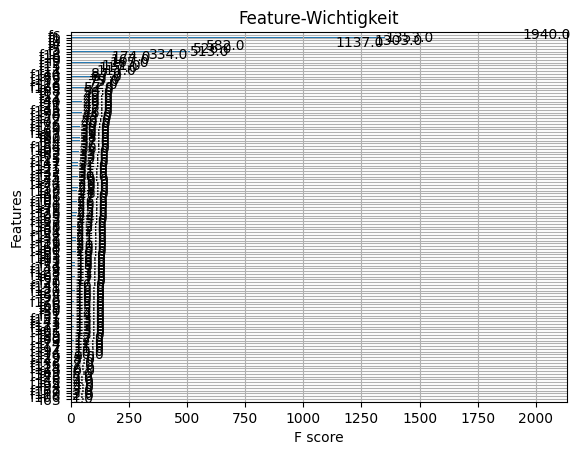

In [146]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Feature-Wichtigkeit plotten
plot_importance(model, importance_type='weight')
plt.title('Feature-Wichtigkeit')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Parameter-Raster
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [1.0]
}

# Grid Search
grid_search = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Training
#grid_search.fit(X_train, y_train)

# Beste Parameter anzeigen
print(f"Beste Parameter: {grid_search.best_params_}")
print(f"Beste Genauigkeit: {grid_search.best_score_:.2f}")


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\Users\phili\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:22:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Beste Parameter: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Beste Genauigkeit: 0.89


In [149]:
# Wahrscheinlichkeiten vorhersagen
probs = model.predict_proba(X_test)

# Wahrscheinlichkeiten in DataFrame umwandeln
probs_df = pd.DataFrame(probs, columns=label_encoder.classes_)
print(probs_df.head())


       None  human error  incorrect configuration  incorrect data  \
0  0.000130     0.362777                 0.084998        0.130144   
1  0.999985     0.000001                 0.000006        0.000001   
2  0.999975     0.000001                 0.000013        0.000005   
3  0.999979     0.000002                 0.000002        0.000003   
4  0.999985     0.000003                 0.000002        0.000004   

   insufficient capacity  insufficient resources  machine failure  \
0               0.027633            5.507450e-02         0.102648   
1               0.000001            6.812456e-07         0.000001   
2               0.000002            1.018013e-06         0.000002   
3               0.000003            2.526850e-06         0.000006   
4               0.000003            1.235246e-06         0.000001   

   network failure  
0         0.236596  
1         0.000003  
2         0.000002  
3         0.000002  
4         0.000001  


In [31]:
#model.save_model("xgboost_model.json")

from xgboost import XGBClassifier

# # Laden des Modells aus der Datei
model = XGBClassifier()
model.load_model("xgboost_model.json")


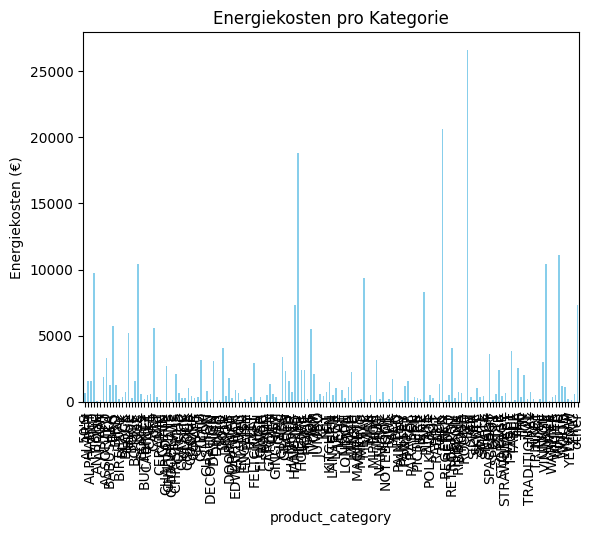

In [32]:
import matplotlib.pyplot as plt

category_costs.plot(kind='bar', x='product_category', y='Energy_Cost', legend=False, color='skyblue')
plt.title('Energiekosten pro Kategorie')
plt.ylabel('Energiekosten (€)')
plt.show()


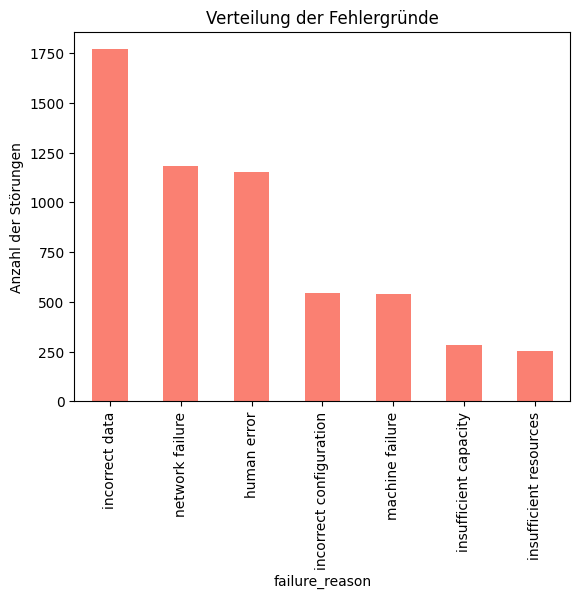

In [33]:

failure_counts.drop('None').plot(kind='bar', color='salmon')
plt.title('Verteilung der Fehlergründe')
plt.ylabel('Anzahl der Störungen')
plt.show()


In [46]:
import pandas as pd
import numpy as np

# Anzahl der zu generierenden Konfigurationen
num_samples = 100000

# Zufällige Maschinenkonfigurationen erstellen
data = {
    'Usage_kWh': np.random.uniform(1, 100, num_samples),
    'Lagging_Current_Reactive.Power_kVarh': np.random.uniform(0, 10, num_samples),
    'Leading_Current_Reactive_Power_kVarh': np.random.uniform(0, 30, num_samples),
    'CO2(tCO2)': np.random.uniform(0, 0.1, num_samples),
    'Lagging_Current_Power_Factor': np.random.uniform(0, 100, num_samples),
    'Leading_Current_Power_Factor': np.random.uniform(0, 100, num_samples),
    'NSM': np.random.choice([0, 43200, 86400], num_samples),  # Sekunden seit Mitternacht
    'WeekStatus': np.random.choice(['Weekday', 'Weekend'], num_samples),
    'Day_of_week': np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], num_samples),
    'Load_Type': np.random.choice(['Light_Load', 'Medium_Load', 'High_Load'], num_samples),
    'country': np.random.choice(['United Kingdom', 'France', 'Germany'], num_samples),
    'machine_no': np.random.randint(1, 4, num_samples),
    'product_category': np.random.choice(df.product_category.drop_duplicates(), num_samples)
}

# DataFrame erstellen
df_new = pd.DataFrame(data)

# One-Hot-Encoding für kategorische Variablen
df_encoded = pd.get_dummies(df_new, columns=['WeekStatus', 'Day_of_week', 'Load_Type', 'country', 'product_category'], drop_first=True)

# Skalierung (optional, falls Modell es erfordert)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(df_encoded)

# Vorhersage der wahrscheinlichsten Störung mit dem XGBoost-Modell
probs = model.predict_proba(X_new_scaled)

# Wahrscheinlichkeiten in DataFrame umwandeln
probs_df = pd.DataFrame(probs, columns=label_encoder.classes_)

# Wahrscheinlichste Störung und ihre Wahrscheinlichkeit speichern
df_new['predicted_failure'] = probs_df.idxmax(axis=1)
df_new['predicted_probability'] = probs_df.max(axis=1)

# Ergebnisse anzeigen
print(df_new.head())

   Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0  80.337285                              6.385141   
1  12.958803                              8.879574   
2  75.249925                              9.729947   
3  74.964269                              8.901865   
4  80.238760                              5.961837   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                             26.000602   0.079837   
1                             14.721022   0.065805   
2                             11.163314   0.061519   
3                             22.967383   0.032999   
4                              0.181730   0.022331   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor    NSM  \
0                     96.423884                     18.246342  43200   
1                     65.718595                      9.838442  86400   
2                     94.412429                      9.403780  86400   
3                     24.055349                     44.907527 

In [47]:
for col in df_new.select_dtypes(include=['number']).columns.tolist():
    df_new[col] = round(df_new[col], 2)

In [ ]:
df_new.to_csv("machine_configurations_with_predictions.csv", index=False, sep=';', decimal=',')

Datensatz gespeichert.
